In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
Clinical_data = pd.read_csv("clinical/clinical.tsv", sep = '\t')
print(f'Clinical data has {Clinical_data.shape[0]} rows and {Clinical_data.shape[1]} columns.')
#Clinical_data.head()

Clinical data has 444 rows and 28 columns.


In [3]:
Exposure_data = pd.read_csv("clinical/exposure.tsv", sep = '\t')
print(f'Exposure data has {Exposure_data.shape[0]} rows and {Exposure_data.shape[1]} columns.')
pd.set_option('display.max_columns', None)
#Exposure_data.head()

Exposure data has 444 rows and 10 columns.


In [4]:
All_Dataset = pd.merge(Clinical_data, Exposure_data, how = 'outer', on =['case_id', 'submitter_id', 'project_id'])
All_Dataset.to_csv( "All_Dataset.csv")
print(f'All_data file has {All_Dataset.shape[0]} rows and {All_Dataset.shape[1]} columns.')
#All_Dataset.head(5)

All_data file has 444 rows and 35 columns.


In [5]:
All_Dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   case_id                            444 non-null    object
 1   submitter_id                       444 non-null    object
 2   project_id                         444 non-null    object
 3   gender                             444 non-null    object
 4   year_of_birth                      444 non-null    object
 5   race                               444 non-null    object
 6   ethnicity                          444 non-null    object
 7   year_of_death                      444 non-null    object
 8   classification_of_tumor            444 non-null    object
 9   last_known_disease_status          444 non-null    object
 10  primary_diagnosis                  444 non-null    object
 11  tumor_stage                        444 non-null    object
 12  age_at_d

gender
male      231
female    211
--          2
Name: count, dtype: int64


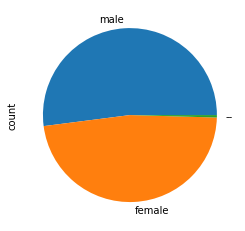

In [6]:
gender = All_Dataset['gender'].value_counts(dropna = 'True')
print(gender)
Gender = gender.plot.pie()

race
white                               213
not reported                        158
black or african american            59
asian                                11
--                                    2
american indian or alaska native      1
Name: count, dtype: int64


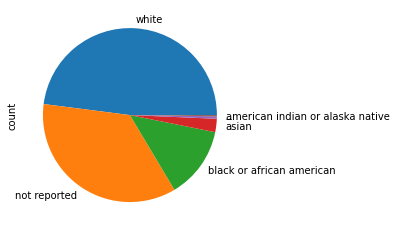

In [7]:
race = All_Dataset['race'].value_counts(dropna = 'True')
print(race)
Race = race.plot.pie()

In [8]:
tumour_stage = All_Dataset['tumor_stage'].value_counts(dropna = 'True')
print(tumour_stage)

tumor_stage
stage iia       129
stage i          72
stage iiib       59
stage iv         46
stage iiic       39
stage ii         29
stage iii        20
stage iva        17
not reported     11
stage iib         9
stage iiia        7
stage ivb         2
--                2
stage iic         1
stage ia          1
Name: count, dtype: int64


In [9]:
All_Dataset.loc[All_Dataset.tumor_stage == "stage ia" ,'tumor_stage'] = "stage i"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iia" ,'tumor_stage'] = "stage ii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iib" ,'tumor_stage'] = "stage ii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iic" ,'tumor_stage'] = "stage ii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iiia" ,'tumor_stage'] = "stage iii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iiib" ,'tumor_stage'] = "stage iii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iiic" ,'tumor_stage'] = "stage iii"
All_Dataset.loc[All_Dataset.tumor_stage == "stage iva" ,'tumor_stage'] = "stage iv"
All_Dataset.loc[All_Dataset.tumor_stage == "stage ivb" ,'tumor_stage'] = "stage iv"

All_Dataset.loc[All_Dataset.tumor_stage == "not reported" ,'tumor_stage'] = 0
All_Dataset.loc[All_Dataset.tumor_stage == "--" ,'tumor_stage'] = 0

All_Dataset['tumor_stage'].value_counts()

tumor_stage
stage ii     168
stage iii    125
stage i       73
stage iv      65
0             13
Name: count, dtype: int64

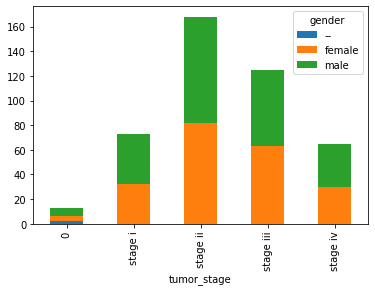

In [10]:
All_Dataset.groupby(['tumor_stage','gender']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [11]:
All_Dataset['vital_status'].value_counts(dropna = 'True')

vital_status
alive    341
dead     101
--         2
Name: count, dtype: int64

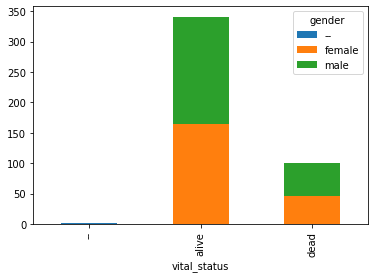

In [12]:
vit_stat = All_Dataset.groupby(['vital_status','gender']).size().unstack().plot(kind='bar',stacked=True)
plt.show(vit_stat)

days_to_death
5000.0    343
0.0         4
61.0        4
153.0       4
306.0       3
         ... 
496.0       1
1348.0      1
338.0       1
1381.0      1
2003.0      1
Name: count, Length: 89, dtype: int64

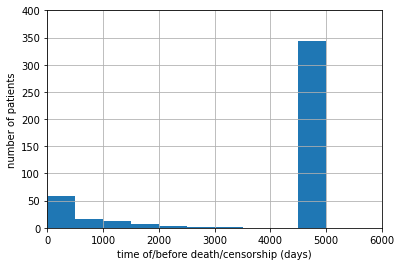

In [13]:
#vit_stat = All_Dataset.groupby(['days_to_death','gender']).size().unstack().plot(kind='bar',stacked=True)
#plt.show(vit_stat)
All_Dataset.loc[All_Dataset.days_to_death == "--" ,'days_to_death'] = 5000
All_Dataset['days_to_death'] = pd.to_numeric(All_Dataset["days_to_death"], downcast="float")
#plt.plot(All_Dataset['days_to_death'])
All_Dataset.days_to_death.hist()
plt.xlabel("time of/before death/censorship (days)")
plt.ylabel("number of patients")
plt.axis([0, 6000, 0, 400])
plt.grid(True)
All_Dataset['days_to_death'].value_counts(dropna = 'True')

In [14]:
All_Dataset.loc[All_Dataset.vital_status == "dead" ,'survival'] = 1
All_Dataset.loc[All_Dataset.vital_status == "alive",'survival'] = 0
pd.set_option('display.max_columns', None)


In [15]:
import datetime
now = datetime.datetime.now()
All_Dataset.loc[All_Dataset['year_of_death'] == '--', 'age'] = now.year - pd.to_numeric(All_Dataset['year_of_birth'], errors='coerce')
All_Dataset.loc[All_Dataset['age'].isnull(), 'age'] = pd.to_numeric(All_Dataset['year_of_death'] ,errors='coerce') - pd.to_numeric(All_Dataset['year_of_birth'], errors='coerce')

#All_Dataset.head()

In [16]:
kmf = KaplanMeierFitter()
kmc = KaplanMeierFitter()

Male = All_Dataset['gender']== 'male'
Male_d = All_Dataset[Male]['days_to_death']
Male_Sur = All_Dataset[Male]['survival']

Female = All_Dataset['gender']== 'female'
Female_d = All_Dataset[Female]['days_to_death']
Female_Sur = All_Dataset[Female]['survival']

kmf.fit(Male_d, event_observed = Male_Sur, label = "Male Survival")
kmc.fit(Female_d, event_observed = Female_Sur, label = "Female Survival")

<lifelines.KaplanMeierFitter:"Female Survival", fitted with 211 total observations, 165 right-censored observations>

In [17]:
kmc.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,2,2,0,211,211
29.0,1,1,0,0,209
30.0,1,1,0,0,208
59.0,1,1,0,0,207
61.0,1,1,0,0,206
90.0,1,1,0,0,205
92.0,1,1,0,0,204
153.0,2,2,0,0,203
156.0,1,1,0,0,201


In [18]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,2,2,0,231,231
43.0,1,1,0,0,229
49.0,1,1,0,0,228
61.0,3,3,0,0,227
97.0,1,1,0,0,224
146.0,1,1,0,0,223
153.0,2,2,0,0,222
159.0,1,1,0,0,220
176.0,1,1,0,0,219


In [19]:
kmf.survival_function_

,Male Survival
timeline,
0.0,0.991342
43.0,0.987013
49.0,0.982684
61.0,0.969697
97.0,0.965368
146.0,0.961039
153.0,0.952381
159.0,0.948052
176.0,0.943723


In [20]:
kmc.survival_function_

,Female Survival
timeline,
0.0,0.990521
29.0,0.985782
30.0,0.981043
59.0,0.976303
61.0,0.971564
90.0,0.966825
92.0,0.962085
153.0,0.952607
156.0,0.947867


Text(0.5, 1.0, 'Kaplan Meier estimates')

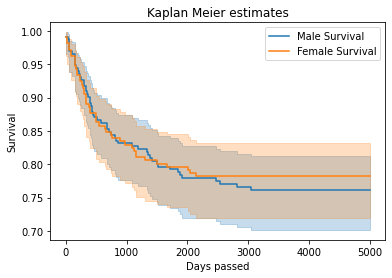

In [21]:
# Plot the survival_function data :
kmf.plot()
kmc.plot()

plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("Kaplan Meier estimates")

In [22]:
print("The median survival time for males is [",kmc.median_survival_time_,"], and for females is [", kmf.median_survival_time_ ,"]")
print(" ")
print("",kmc.survival_function_," \n \n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n", kmf.survival_function_ ," ")

The median survival time for males is [ inf ], and for females is [ inf ]
 
           Female Survival
timeline                 
0.0              0.990521
29.0             0.985782
30.0             0.981043
59.0             0.976303
61.0             0.971564
90.0             0.966825
92.0             0.962085
153.0            0.952607
156.0            0.947867
172.0            0.943128
179.0            0.938389
188.0            0.933649
228.0            0.928910
236.0            0.924171
262.0            0.919431
290.0            0.914692
306.0            0.905213
334.0            0.900474
335.0            0.895735
338.0            0.890995
383.0            0.886256
396.0            0.881517
403.0            0.876777
494.0            0.872038
496.0            0.867299
504.0            0.862559
549.0            0.857820
643.0            0.853081
670.0            0.848341
740.0            0.843602
758.0            0.838863
899.0            0.834123
972.0            0.829384
1095.0       

# Kaplan Meier per Age Group

In [23]:
# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = All_Dataset.groupby('gender').agg({'age': ['mean', 'min', 'max']})

print(grouped_single)

              age             
             mean   min    max
gender                        
--            NaN   NaN    NaN
female  79.322275  35.0  111.0
male    80.125541  37.0  106.0


All_Dataset.head()

In [24]:
kmfs1 = KaplanMeierFitter()
kmfs2 = KaplanMeierFitter()
kmfs3 = KaplanMeierFitter()
kmfs4 = KaplanMeierFitter()


STG_1 = All_Dataset['tumor_stage']== 'stage i'
Male_d1 = All_Dataset[STG_1]['days_to_death']
Male_Sur1 = All_Dataset[STG_1]['survival']

STG_2 = All_Dataset['tumor_stage']== 'stage ii'
Male_d2 = All_Dataset[STG_2]['days_to_death']
Male_Sur2 = All_Dataset[STG_2]['survival']

STG_3 = All_Dataset['tumor_stage']== 'stage iii'
Male_d3 = All_Dataset[STG_3]['days_to_death']
Male_Sur3 = All_Dataset[STG_3]['survival']

STG_4 = All_Dataset['tumor_stage']== 'stage iv'
Male_d4 = All_Dataset[STG_4]['days_to_death']
Male_Sur4 = All_Dataset[STG_4]['survival']


kmfs1.fit(Male_d1, event_observed = Male_Sur1, label = " Tumor_Stage1")
kmfs2.fit(Male_d2, event_observed = Male_Sur2, label = " Tumor_Stage2")
kmfs3.fit(Male_d3, event_observed = Male_Sur3, label = " Tumor_Stage3")
kmfs4.fit(Male_d4, event_observed = Male_Sur4, label = " Tumor_Stage4")


<lifelines.KaplanMeierFitter:" Tumor_Stage4", fitted with 65 total observations, 34 right-censored observations>

Text(0.5, 1.0, 'Kaplan Meier estimates per cancer stage')

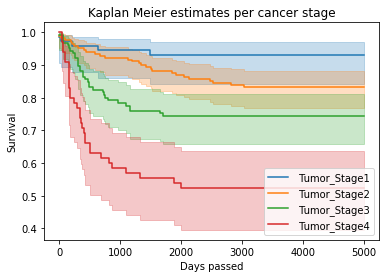

In [25]:
kmfs1.plot()
kmfs2.plot()
kmfs3.plot()
kmfs4.plot()

plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("Kaplan Meier estimates per cancer stage")

However when segment the sample by the stage of the cancer at diagnosis, we can clearly see that Stage 3 and Stage 4  cancer results in especially accelerated rates of death.

In [26]:
from lifelines.statistics import logrank_test
summary= logrank_test(Male_d1, Male_d4, Male_Sur1, Male_Sur4)

print (summary)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          29.97 <0.005     24.44
